In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the TSV file
file_path = 'adjudicated.txt'
df = pd.read_csv(file_path, sep='\t', header=None, names=['Index', 'Type', 'Label', 'Text'])

# Define sizes for train, dev, and test
n_total = len(df)
n_train = 300
n_dev_test = 200  # Total for dev and test
n_dev = 100
n_test = 100

# Split data into train and a temporary dev_test set
train, dev_test = train_test_split(df, train_size=n_train, stratify=df['Label'], random_state=42)

# Split dev_test into dev and test sets
dev, test = train_test_split(dev_test, train_size=n_dev, stratify=dev_test['Label'], random_state=42)

# Output the first few rows of each set to verify
print("Train:\n", train.head())
print("Dev:\n", dev.head())
print("Test:\n", test.head())

# Write the train, dev, and test DataFrames to .txt files with no headers and no index
train.to_csv('train.txt', sep='\t', index=False, header=False)
dev.to_csv('dev.txt', sep='\t', index=False, header=False)
test.to_csv('test.txt', sep='\t', index=False, header=False)


Train:
      Index         Type Label  \
84      85  adjudicated    FP   
33      33  adjudicated    FP   
276    278  adjudicated  TPOB   
77      78  adjudicated  TPOB   
183    185  adjudicated   TPL   

                                                  Text  
84   For a moment a phrase tried to take shape in m...  
33   Then new arrivals deranged the line, and Jorda...  
276  The soldiers interposed their bayonets, for th...  
77   The submarine railway may have its difficultie...  
183  To love mankind FOR GOD'S SAKE—this has so far...  
Dev:
      Index         Type Label  \
303    305  adjudicated    FP   
222    224  adjudicated    FP   
197    199  adjudicated    FP   
464    466  adjudicated    FP   
316    318  adjudicated   TPL   

                                                  Text  
303        I want to wait here till Daisy goes to bed.  
222              I ought to have left it in the shade.  
197  I enjoyed the counter-raid so thoroughly that ...  
464  It was a matt

Number of unique labels: 5
{'FP': 0, 'AB': 1, 'TPL': 2, 'TPOM': 3, 'TPOB': 4}
Sample data from train.txt : [('For a moment a phrase tried to take shape in my mouth and my lips parted like a dumb man’s, as though there was more struggling upon them than a wisp of startled air.', 0), ('Then new arrivals deranged the line, and Jordan and I were pushed suddenly inside.', 0), ('The soldiers interposed their bayonets, for they thought that he was about to attack the inspector, and the latter recoiled two or three steps. Dantès saw that he was looked upon as dangerous. Then, infusing all the humility he possessed into his eyes and voice, he addressed the inspector, and sought to inspire him with pity.', 4), ('The submarine railway may have its difficulties; but the bed of the sea is not divided among various landed proprietors with claims for damages not only measurable but sentimental.', 4), ('"To love mankind FOR GOD\'S SAKE—this has so far been the noblest and remotest sentiment to which m

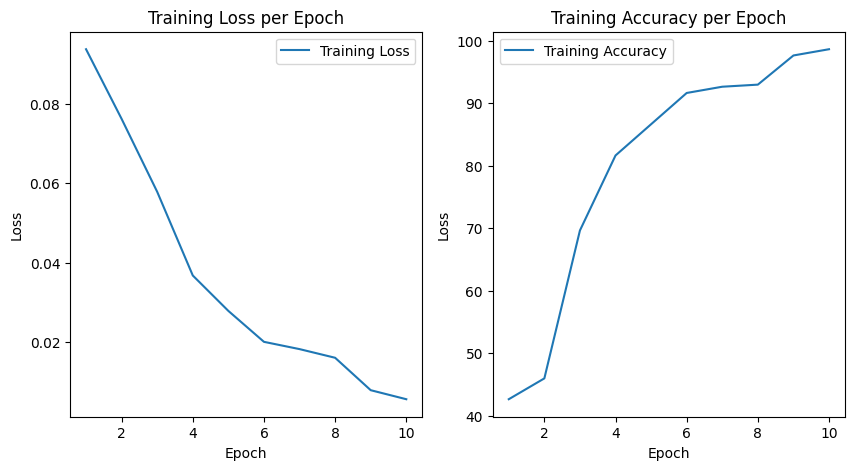

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
from sklearn.metrics import confusion_matrix, accuracy_score



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class EnhancedBERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(EnhancedBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name, output_attentions=True)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # Make sure to return both logits and attention
        return logits, outputs.attentions



def train_model(model, train_data, dev_data, tokenizer, optimizer, criterion, num_epochs=10, batch_size=32):
    # initalize lists to store training/validation metrics
    train_losses = []
    train_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total, correct = 0, 0

        for i in range(0, len(train_data), batch_size):
            batch_texts, batch_labels = zip(*train_data[i:i+batch_size])
            batch_labels = torch.tensor(batch_labels, dtype=torch.long, device=device)

            tokenized = tokenizer(list(batch_texts), padding=True, truncation=True, return_tensors="pt").to(device)
            input_ids = tokenized['input_ids']
            attention_mask = tokenized['attention_mask']

            optimizer.zero_grad()
            # Unpack the tuple to get the logits only
            logits, _ = model(input_ids, attention_mask)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        epoch_loss = running_loss / len(train_data)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {100 * correct / total}')

    return train_losses, train_accuracies

def evaluate_model(model, data, tokenizer):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for texts, labels in data:
            tokenized = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(tokenized['input_ids'], tokenized['attention_mask'])
            _, predicted = torch.max(outputs, dim=1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels)  # Extend the true_labels list with the labels for the current batch

    accuracy = accuracy_score(true_labels, predictions)
    conf_mat = confusion_matrix(true_labels, predictions)
    return accuracy, conf_mat




def read_labels(filename):
    with open(filename, 'r') as file:
        labels = set()
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) > 1:
                labels.add(parts[2])
    print("Number of unique labels:", len(labels))  # Debug: Print number of unique labels
    return list(labels)


def label_to_integer(label):
    label_mapping = {
        'FP': 0,
        'AB': 1,
        'TPL': 2,
        'TPOM': 3,
        'TPOB': 4
    }
    return label_mapping[label]

def read_data(filename, label_mapping):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) > 2:
                label = parts[2]  # Assuming the second part is the label
                text = parts[3]  # Assuming the first part is the text
                if label in label_mapping:
                    data.append((text, label_to_integer(label)))
                else:
                    print(f"Unknown label: {label}")
    print("Sample data from", filename, ":", data[:5])
    return data


def main():
    labels = read_labels("train.txt")
    num_classes = len(labels)
    model = EnhancedBERTClassifier("bert-base-cased", num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()

    label_mapping = {
        'FP': 0,
        'AB': 1,
        'TPL': 2,
        'TPOM': 3,
        'TPOB': 4
    }
    print(label_mapping)

    train_data = read_data("train.txt", label_mapping)
    dev_data = read_data("dev.txt", label_mapping)

    tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

    train_losses, train_accuracies = train_model(model, train_data, dev_data, tokenizer, optimizer, criterion, num_epochs=10, batch_size=16)

    torch.save(model.state_dict(), "enhanced_bert_model.pth")

    epochs = range(1, 11)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
model = EnhancedBERTClassifier("bert-base-cased", 5).cuda()
model.load_state_dict(torch.load("enhanced_bert_model.pth"))
model.eval()



EnhancedBERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import binom, norm

label_mapping = {
        'FP': 0,
        'AB': 1,
        'TPL': 2,
        'TPOM': 3,
        'TPOB': 4
    }

train_data = read_data("train.txt", label_mapping)
dev_data = read_data("dev.txt", label_mapping)


def calculate_accuracy_confidence_interval(y_true, y_pred, confidence_level=0.95):
    """
    Calculates the accuracy and the confidence interval for a given confidence level.

    Args:
    y_true (list or array): True labels.
    y_pred (list or array): Predicted labels.
    confidence_level (float): The confidence level for the interval.

    Returns:
    float: Accuracy.
    tuple: Lower and upper bounds of the confidence interval.
    """
    accuracy = accuracy_score(y_true, y_pred)
    n = len(y_true)

    se = np.sqrt(accuracy * (1 - accuracy) / n)
    z = norm.ppf((1 + confidence_level) / 2)
    margin_error = z * se

    ci_lower = accuracy - margin_error
    ci_upper = accuracy + margin_error

    return accuracy, (ci_lower, ci_upper)

def evaluate_model(model, data, tokenizer):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for texts, labels in data:
            # Prepare input batch
            tokenized = tokenizer([texts], padding=True, truncation=True, return_tensors="pt").to(device)
            input_ids = tokenized['input_ids']
            attention_mask = tokenized['attention_mask']

            logits, _ = model(input_ids, attention_mask)

            _, predicted = torch.max(logits, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend([labels] if isinstance(labels, int) else labels)

    accuracy = accuracy_score(true_labels, predictions)
    conf_mat = confusion_matrix(true_labels, predictions)
    return accuracy, conf_mat, predictions, true_labels

accuracy, conf_mat, y_pred, y_true = evaluate_model(model, dev_data, BertTokenizer.from_pretrained("bert-base-cased"))

accuracy, confidence_interval = calculate_accuracy_confidence_interval(y_true, y_pred)
print("Accuracy:", accuracy)
print("95% Confidence Interval:", confidence_interval)



Sample data from train.txt : [('For a moment a phrase tried to take shape in my mouth and my lips parted like a dumb man’s, as though there was more struggling upon them than a wisp of startled air.', 0), ('Then new arrivals deranged the line, and Jordan and I were pushed suddenly inside.', 0), ('The soldiers interposed their bayonets, for they thought that he was about to attack the inspector, and the latter recoiled two or three steps. Dantès saw that he was looked upon as dangerous. Then, infusing all the humility he possessed into his eyes and voice, he addressed the inspector, and sought to inspire him with pity.', 4), ('The submarine railway may have its difficulties; but the bed of the sea is not divided among various landed proprietors with claims for damages not only measurable but sentimental.', 4), ('"To love mankind FOR GOD\'S SAKE—this has so far been the noblest and remotest sentiment to which mankind has attained. That love to mankind, without any redeeming intention in 

In [ ]:
num_classes = 5
model = EnhancedBERTClassifier("bert-base-cased", num_classes).to(device)

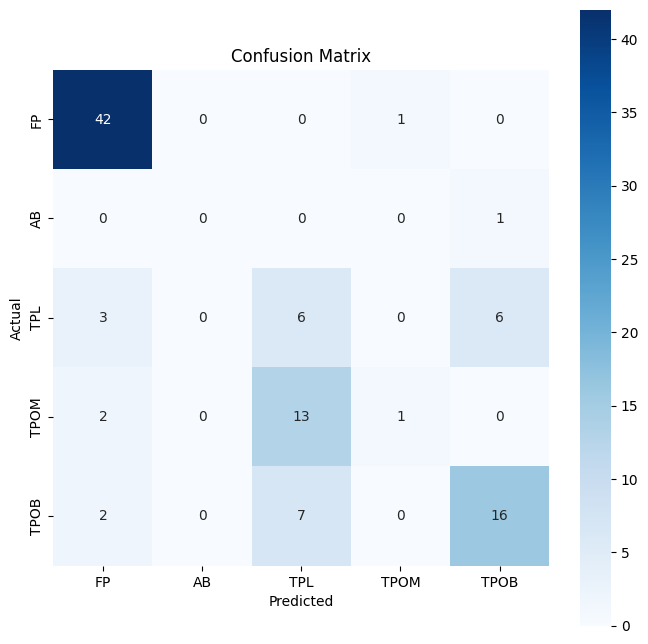

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', square=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# class names
class_names = ['FP', 'AB', 'TPL', 'TPOM', 'TPOB']  # or however you have defined them

# Load model
model = EnhancedBERTClassifier('bert-base-cased', len(class_names))
model.load_state_dict(torch.load('enhanced_bert_model.pth'))
model = model.to(device)
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
accuracy, conf_mat, y_pred, y_true = evaluate_model(model, dev_data, tokenizer)
plot_confusion_matrix(y_true, y_pred, class_names)




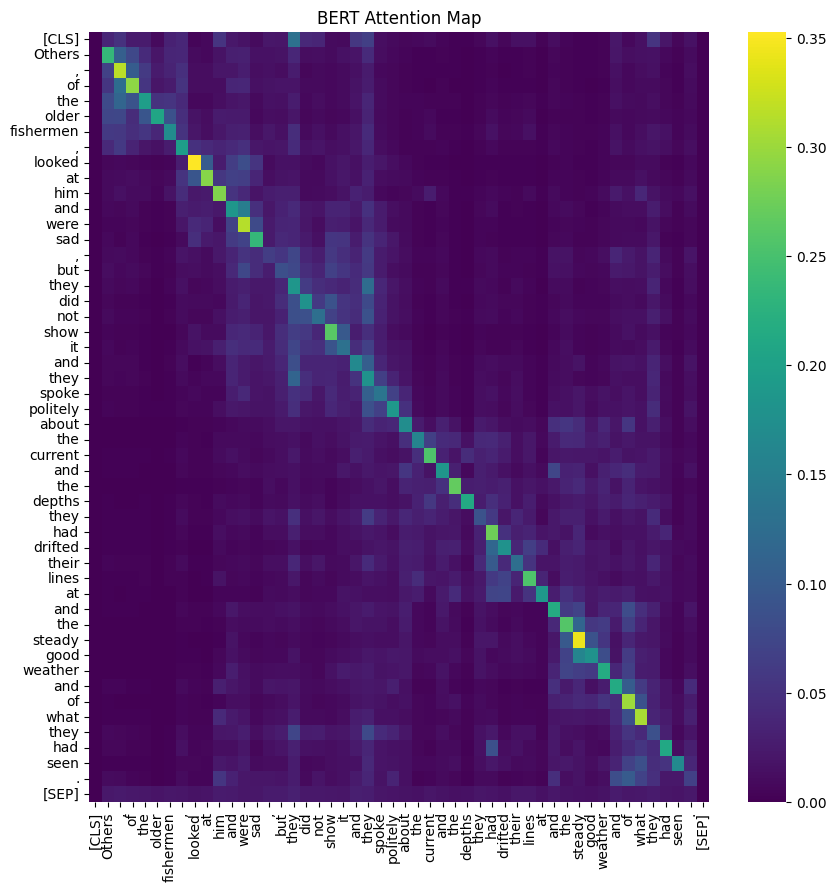

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(input_sentence, model, tokenizer):
    model.eval()
    inputs = tokenizer(input_sentence, return_tensors="pt").to(device)
    inputs['attention_mask'][0][0] = 0
    inputs['attention_mask'][0][-1] = 0
    logits, attentions = model(inputs['input_ids'], inputs['attention_mask'])

    attention = torch.mean(attentions[-1], dim=1)  # Last layer's attentions
    attention = attention.squeeze(0).cpu().detach().numpy()  # Convert to numpy array

    fig, ax = plt.subplots(figsize=(10, 10))
    tokenized_sentence = ["[CLS]"] + tokenizer.tokenize(input_sentence) + ["[SEP]"]

    sns.heatmap(attention, xticklabels = tokenized_sentence, yticklabels = tokenized_sentence, ax=ax, cmap='viridis')
    plt.title('BERT Attention Map')
    plt.show()

plot_attention("Others, of the older fishermen, looked at him and were sad, but they did not show it and they spoke politely about the current and the depths they had drifted their lines at and the steady good weather and of what they had seen.", model, tokenizer)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


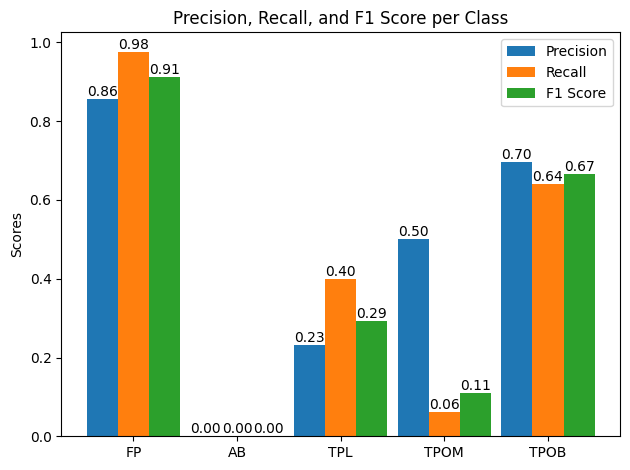

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
class_labels = ['FP', 'AB', 'TPL', 'TPOM', 'TPOB']

fig, ax = plt.subplots()
x = np.arange(len(class_labels))
bar_width = 0.3
ax.bar(x - bar_width, precision, bar_width, label='Precision')
ax.bar(x, recall, bar_width, label='Recall')
ax.bar(x + bar_width, f1, bar_width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_title('Precision, Recall, and F1 Score per Class')
ax.legend()

for rects in ax.patches:
    ax.annotate(f'{rects.get_height():.2f}', (rects.get_x() + rects.get_width() / 2, rects.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from torch.nn.functional import softmax

def roc_auc_score_multiclass(actual_class, pred_logits, tokenizer, model, data, average="macro"):

    texts = [text for text, _ in data]
    tokenized = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    input_ids, attention_mask = tokenized['input_ids'], tokenized['attention_mask']

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask)[0]
        probabilities = softmax(logits, dim=1).cpu().numpy()


    actual_class = [label for _, label in data]
    unique_classes = set(actual_class)
    roc_auc_dict = {}

    for per_class in unique_classes:

        new_actual_class = [1 if x == per_class else 0 for x in actual_class]
        new_pred_prob = [prob[per_class] for prob in probabilities]

        roc_auc = roc_auc_score(new_actual_class, new_pred_prob, average=average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [ ]:
for yp, yt, i in zip(y_pred, y_true, range(100)):
    if yp != yt:
        print(yp, yt, dev_data[i])

0 2 ('He can see in the dark—no small power this, in a world which is one half shut from the light. Ah, but hear me through. He can do all these things, yet he is not free. Nay; he is even more prisoner than the slave of the galley, than the madman in his cell. He cannot go where he lists; he who is not of nature has yet to obey some of nature’s laws—why we know not.', 2)
3 0 ('"Beyond a doubt, they do wish him to chuse Miss Darcy, replied Jane; ""but this may be from better feelings than you are supposing. They have known her much longer than they have known me; no wonder if they love her better. But, whatever may be their own wishes, it is very unlikely they should have opposed their brother\'s. What sister would think herself at liberty to do it, unless there were something very objectionable? If they believed him attached to me, they would not try to part us; if he were so, they could not succeed. By supposing such an affection, you make every body acting unnaturally and wrong, and

### Analysis (Part B)
For the analysis portion of your assignment, consider these steps:

**Confusion Matrix:** Print and analyze the confusion matrix to identify which labels are often mistaken for one another.

**Feature Importance:** If using logistic regression or another interpretable model, analyze the weights to determine which features (words, phrases, syntactic patterns) are most influential.

**Error Analysis:** Manually inspect a subset of incorrect predictions to categorize types of errors and potential biases.

**Bias Analysis:** Assess performance across different slices of your data (e.g., different narrative styles or genres if applicable) to check for model biases.

## Confusion Matrix Analysis
When analyzing the confusion matrix, Third Person Limited (TPL), Third Person Objective (TPOB), and Third Person Omiscient (TPOM) are most often mistaken for eachother. These are likely attributable to three main factors (1) quality of ground truth data, (2) class imbalances and (3) deep semantic knowledge needed to differentiate each of these classes.

Even after iterating the labeling guidelines, there was still disagreement between annotators when it came to thirs-person class assignment. Furhter iterations of guidelines and additional annotators would likely improve the ability for a language model to differentiate the classes.

Becasue of the nature of each of the labeled classes, there is a signficant class imbalance. This can be due to the excerpts and data selected to randomly sample from when creating the training data. To alleviate this, addition, diverse pieces of text can be sampled from when making an augmented corpus. This was attenuated as best as the group could by including equal portions of each class (randomly sampled) within training batches.

Lastly, just as it is difficult for human annotators to differentiate TPL/TPOM/TPOB due to the multiple perspectives one can interpret the text by (aided by guidelines), so is it for any language-based model. Attention gives the model a method for which inter-word relationships can be leveraged for preditive power.

---

## Feature Importance Analysis

Looking to feature importance, when averaging out the attention masks of the final layer in the pretrained BERT model used, it can be seen a large amount of attention for a token is attributed to the ending [SEP] token, the starting [CLS] token, and the same word passed as input. To better evluate attention over the sentence, the mask was modified to only allow attention to be done over sentence tokens, not padding tokens.

For the given first-person sentence, *I enjoyed the counter-raid so thoroughly that I came back restless*, it can be seen that the token **"I"** is heavily attended to. This makes sense as the inclusion of **"I"** within a sentence is an important indicator of first-person speaker perspective.

The same phenonenon can be observed with the first-person sentence: *For a moment a phrase tried to take shape in my mouth and my lips parted like a dumb man’s, as though there was more struggling upon them than a wisp of startled air.* While the attention given to **"my"** is not as strong as the first-person indicator in the previous sentence, this can be due to the longer and more complex structure. Interestingly, both **'s** and **them** recieved a comparatively large amount of attention across many of the words. The **'s** modifies an entity while **them** is a subject. Since our task deals with defining speaker point of view, the *type* of subjects in the text could carry relevant information.   

This is further corroborated in the first-person example: *Only gradually did I become aware that the automobiles which turned expectantly into his drive stayed for just a minute and then drove sulkily away.* A large amount of attention is given to **"I", "his", "##lk"** which are either subjects or entity-modifying tokens.

Lastly, in all the above examples the ending period (**"."**) always has signficant attention dedicated to it. This is likely due to the importance of knowing where the end-of-sentence is.

When analyzing the attention masks for third-person sentences (either due to the difficulty in correct classification or deem semantic knowledge needed) attention is spread out more uniformly amongst each token. Subjects and entities (such as but not limited to: he, his, she, hers, they're, them) do recieve a larger portion of attention.

For longer sequence third-person sentences, the same trend continued, albiet attention for given word were clustered around clauses or tightly related phrases. For exmaple, the phrase *"the current and the depths they had drifted their lines at"* has most of its constituent tokens pointing towards others within the phrase. Almost no attention was dedicated to words before or after the phrase. This may reflect a need for the Pre-trained BERT model to, once a sequence becomes long enough, divide it into chunks which are later used in making a decision about category.

---

## Error/Bias Analysis

A large portion of the error cases contain dialogue (which adds a layer of complexity) are edge cases in which an arguement can be made for both the predicted and ground truth labels, and/or are from excepts of older works. For example, the sentence "But every one around her disapproved" was incorrectly labeled as TPL because of the inclusion of "her" as the subject, but the predicted label of TPOM is actually correct because "disapproval" is a revealed emotion shared by (what is implied as) multiple people.  Incorrect labels tend to mis-match between Third-Person Limited (TPL) and Third-Persom Objective (TPOB) and involve longer sentences. TPL describes a perspective from a specific character while TPOM describes the world as it appears and does not have access to any character's inner feelings or emotions. Differentiating these two classes could come down to infering if character-specific emotion exists within the excerpt; this is hard given the limited context/length of the inputs. Lastly, the prevalence of older works within the errors section suggests that either (or both) guidelines do not allow human annotators to label these examples correctly or the pre-trained BERT model may not have access to sufficient amount of older text (or newer texts, because they are more widely avalible, cause an imbalance in the training dataset).

---

## Precision, Recall, and F1 Score Analysis

Precision, recall, and F1 score were calculated for each class. First person has the highest scores across the board, with a precision score of 0.86, a recall score of 0.98, and an F1 score of 0.91. This indicates taht the model was very good at distuinguinshing first person apart from other point of views, and performs far better than any other pov.

The model performs poorly with Third person limited (TPL), with a precision score of 0.23, a recall score of 0.40, and an F1 score of 0.29. The model failes to correctly identify TPL 23% of the time and is only anble to identify 40% of the total occurences of TPL, resulting in a low F1 score.

The model also struggles with Third person omniscient, with a precision score of 0.50, a recall score of 0.06, and an F1 score of 0.11. The model is only correct half of the time, and is only able to properly identify 6% of the total occurences of TPO.

The model performs far better when it comes to Third person objective with a precision score of 0.70, a recall score of 0.64, and an F1 score of 0.67. It is able to correctly identify TPOB 70% of the time and correctly identify 64% of total occurences.

Overall the model is able to perform very will in distuingishing first person from third person, but struggles to differentiate the different categories of third person. This is not completly surprising given that third person limited and third person omniscient are very difficult to distuingish, even for humans. It is difficult to distuinsigh whether third person limited apart from third person omniscient due to the need for nuanced contextual differences, and a lack of features properly explicitly distinguishing the two. Third person objective does not include the thoughts of individual, making it far easier to identify with the local contextual capabilities of the model.